# Day 6: Cointegration
## Week 3: Time Series Analysis for Finance

---

### 🎯 Learning Objectives
- Understand cointegration vs correlation
- Apply Engle-Granger and Johansen tests
- Build pairs trading strategies
- Error correction models (ECM)

---

### 📈 Why Cointegration Matters in Trading

**What is Cointegration?**

Two (or more) non-stationary series that move together in a long-run equilibrium. Their SPREAD is stationary (mean-reverting).

### The Key Insight for Trading

| Concept | Meaning | Trading Implication |
|---------|---------|---------------------|
| **Correlation** | Move together NOW | Can break any time |
| **Cointegration** | Move together FOREVER | Reliable long-term relationship |
| **Spread** | Difference between cointegrated pairs | Mean-reverting → tradeable |

### Real-World Applications

| Use Case | Application |
|----------|-------------|
| **Statistical Arbitrage** | Multi-asset mean reversion |
| **Pairs Selection** | Find which stocks to pair |
| **Hedge Ratio** | How many shares of each |
| **ETF vs Basket** | Exploit index tracking errors |
| **Cross-Market** | ADRs vs local shares |

### Real-World Examples

| Cointegrated Pairs | Why They Move Together |
|-------------------|------------------------|
| GLD vs Physical Gold | Same underlying |
| Shell A vs Shell B | Same company |
| Coke vs Pepsi | Same industry, similar customers |
| SPY vs ES futures | Same index |
| JPM vs GS | Both investment banks |

### When to Use Cointegration Tests

- **Stat Arb Hedge Funds**: Trade 100s of cointegrated pairs
- **Currency Trading**: Interest rate parity relationships
- **ETF Arbitrage**: ETF vs underlying basket
- **Market Makers**: Hedge inventory with cointegrated assets

### 🎯 Primary Trading Application: Pairs Trading

**The Strategy:**
1. Find two cointegrated stocks (e.g., Coca-Cola & Pepsi)
2. Calculate the spread between them
3. When spread deviates → trade for mean reversion
4. Profit when spread returns to normal

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Download market data from Yahoo Finance
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS', 'BAC']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data from Yahoo Finance...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()
log_returns = np.log(prices / prices.shift(1)).dropna()

print(f"✅ Data loaded: {prices.shape[0]} days")

📥 Downloading data from Yahoo Finance...
✅ Data loaded: 1256 days


## 1. Cointegration vs Correlation

### 🎯 The Crucial Difference for Trading

| Property | Correlation | Cointegration |
|----------|-------------|---------------|
| **Time frame** | Short-term | Long-term |
| **Stability** | Changes over time | Stable relationship |
| **Stationarity** | Can be spurious | Requires unit root |
| **Tradeable** | Risky | More reliable |

| JPM vs GS | Both investment banks |

### Why Correlation Can Fool You| SPY vs ES futures | Same index |

| Coke vs Pepsi | Same industry, similar customers |

**Spurious Correlation Problem:**| Shell A vs Shell B | Same company |

- Two random walks can show high correlation| GLD vs Physical Gold | Same underlying |

- But there's NO real relationship|-------------------|------------------------|

- Trading this = losing money| Cointegrated Pairs | Why They Move Together |



### Cointegration = Economic Relationship### Real-World Examples



**When stocks are cointegrated:**- Spread WILL revert to mean

- They share a common factor (e.g., same industry)- Deviations are temporary

CORRELATION vs COINTEGRATION


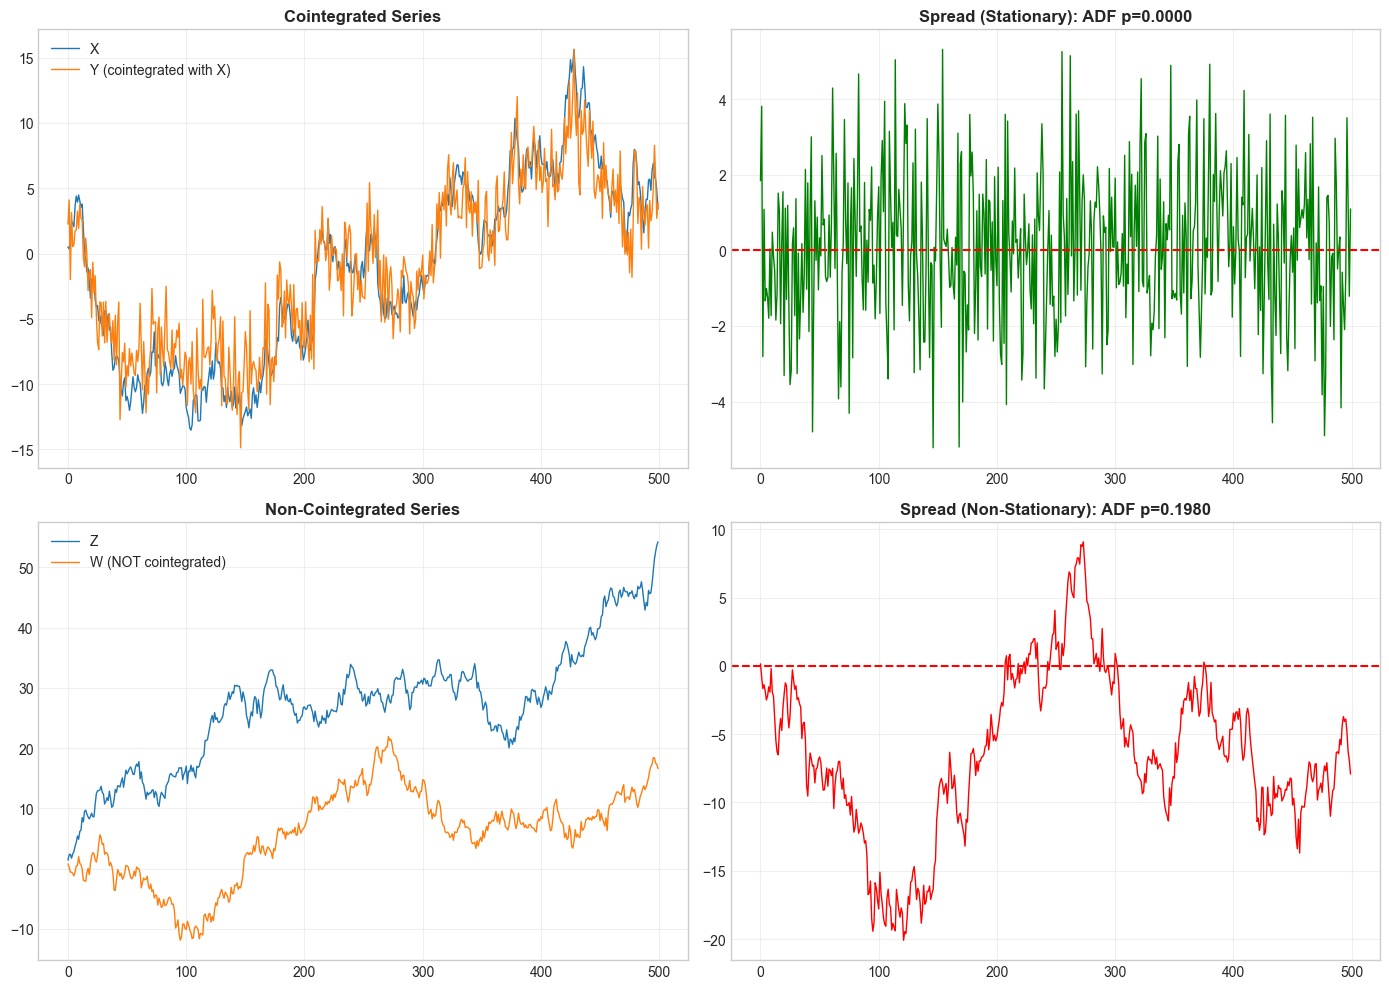


Correlation (X,Y): 0.946 (cointegrated)
Correlation (Z,W): 0.609 (NOT cointegrated)

💡 High correlation doesn't imply cointegration!


In [2]:
# Illustrate the difference
print("=" * 60)
print("CORRELATION vs COINTEGRATION")
print("=" * 60)

np.random.seed(42)
n = 500

# Create cointegrated series
x = np.cumsum(np.random.randn(n))  # Random walk
y = 0.8 * x + np.random.randn(n) * 2  # Cointegrated with x (stationary residual)

# Create correlated but NOT cointegrated series
z = np.cumsum(np.random.randn(n))  # Another random walk (independent)
w = np.cumsum(np.random.randn(n))  # Another random walk

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Cointegrated pair
axes[0,0].plot(x, label='X', lw=1)
axes[0,0].plot(y, label='Y (cointegrated with X)', lw=1)
axes[0,0].set_title('Cointegrated Series', fontweight='bold')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Spread (Y - β*X) should be stationary
beta = np.cov(y, x)[0,1] / np.var(x)
spread_coint = y - beta * x
axes[0,1].plot(spread_coint, lw=1, color='green')
axes[0,1].axhline(0, color='red', linestyle='--')
adf_p = adfuller(spread_coint)[1]
axes[0,1].set_title(f'Spread (Stationary): ADF p={adf_p:.4f}', fontweight='bold')
axes[0,1].grid(True, alpha=0.3)

# Non-cointegrated pair (spurious correlation)
axes[1,0].plot(z, label='Z', lw=1)
axes[1,0].plot(w, label='W (NOT cointegrated)', lw=1)
axes[1,0].set_title('Non-Cointegrated Series', fontweight='bold')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Spread (non-stationary)
beta2 = np.cov(w, z)[0,1] / np.var(z)
spread_noncoint = w - beta2 * z
axes[1,1].plot(spread_noncoint, lw=1, color='red')
axes[1,1].axhline(0, color='red', linestyle='--')
adf_p2 = adfuller(spread_noncoint)[1]
axes[1,1].set_title(f'Spread (Non-Stationary): ADF p={adf_p2:.4f}', fontweight='bold')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCorrelation (X,Y): {np.corrcoef(x, y)[0,1]:.3f} (cointegrated)")
print(f"Correlation (Z,W): {np.corrcoef(z, w)[0,1]:.3f} (NOT cointegrated)")
print("\n💡 High correlation doesn't imply cointegration!")

## 2. Engle-Granger Cointegration Test

### What is Engle-Granger Test?

A two-step method to test if two series are cointegrated:

**Step 1:** Regress Y on X: Y = α + βX + ε

**Step 2:** Test if residuals ε are stationary (ADF test)

### 🎯 Trading Interpretation

| Result | What it Means | Trading Action |
|--------|---------------|----------------|
| **p < 0.05** | Cointegrated | Can trade the pair |
| **p > 0.05** | Not cointegrated | Don't trade as pair |
| **β (beta)** | Hedge ratio | Shares of X per share of Y |

### The Hedge Ratio (β)

**What is β?**

The number of shares of X needed to hedge one share of Y.

| Hedge Ratio | Trade Setup |
|-------------|-------------|
| β = 0.8 | Long 1 share Y, Short 0.8 shares X |
| β = 1.5 | Long 1 share Y, Short 1.5 shares X |

### Critical Warning

**Multiple testing problem:**
- Testing 100 pairs → 5 will appear cointegrated by chance
- Use Bonferroni correction or require lower p-value
- ALWAYS validate out-of-sample

In [3]:
# Engle-Granger test on real data
print("=" * 60)
print("ENGLE-GRANGER COINTEGRATION TEST")
print("=" * 60)

def engle_granger_test(y, x, name='Pair'):
    """Perform Engle-Granger cointegration test."""
    # Step 1: Run OLS regression
    X = np.column_stack([np.ones(len(x)), x])
    model = OLS(y, X).fit()
    alpha, beta = model.params
    residuals = y - alpha - beta * x
    
    # Step 2: ADF test on residuals
    adf_stat, adf_p = adfuller(residuals)[:2]
    
    print(f"\n{name}:")
    print(f"  Regression: Y = {alpha:.4f} + {beta:.4f}*X")
    print(f"  ADF statistic: {adf_stat:.4f}")
    print(f"  ADF p-value:   {adf_p:.4f}")
    
    if adf_p < 0.05:
        print(f"  → COINTEGRATED ✓")
    else:
        print(f"  → NOT cointegrated ✗")
    
    return adf_p, beta, residuals

# Test potential pairs
pairs = [
    ('JPM', 'GS'),      # Banks
    ('JPM', 'BAC'),     # Banks
    ('AAPL', 'MSFT'),   # Tech
    ('AAPL', 'MSFT'),    # Two Tech Stocks
]

results = []
for asset1, asset2 in pairs:
    y = prices[asset1].values
    x = prices[asset2].values
    p_val, beta, resid = engle_granger_test(y, x, f"{asset1}/{asset2}")
    results.append({
        'Pair': f"{asset1}/{asset2}",
        'p-value': p_val,
        'Beta': beta,
        'Cointegrated': 'Yes' if p_val < 0.05 else 'No'
    })

ENGLE-GRANGER COINTEGRATION TEST

JPM/GS:
  Regression: Y = 17.1157 + 0.3730*X
  ADF statistic: 0.3457
  ADF p-value:   0.9793
  → NOT cointegrated ✗

JPM/BAC:
  Regression: Y = -86.4943 + 7.1102*X
  ADF statistic: -1.4127
  ADF p-value:   0.5762
  → NOT cointegrated ✗

AAPL/MSFT:
  Regression: Y = 39.5768 + 0.4093*X
  ADF statistic: -2.3073
  ADF p-value:   0.1696
  → NOT cointegrated ✗

AAPL/MSFT:
  Regression: Y = 39.5768 + 0.4093*X
  ADF statistic: -2.3073
  ADF p-value:   0.1696
  → NOT cointegrated ✗


STATSMODELS COINT() FUNCTION

Cointegration p-values (lower = more likely cointegrated):


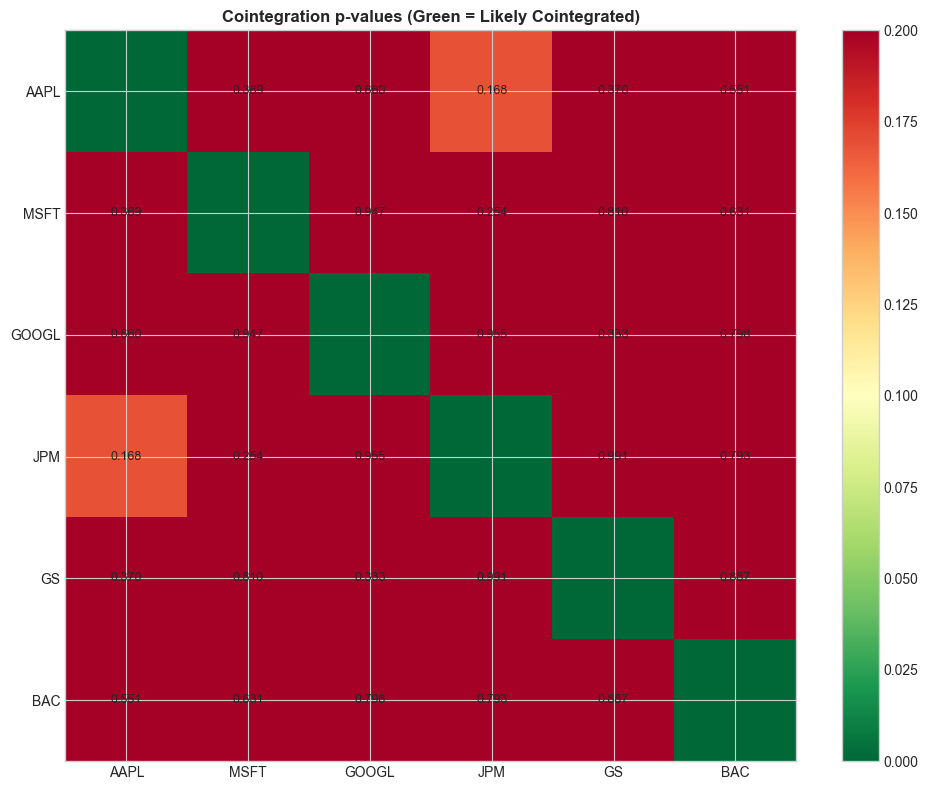


Most Likely Cointegrated Pairs (p < 0.10):


In [4]:
# Using statsmodels coint function
print("=" * 60)
print("STATSMODELS COINT() FUNCTION")
print("=" * 60)

# Scan all pairs
assets = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'GS', 'BAC']
n_assets = len(assets)

coint_matrix = pd.DataFrame(np.zeros((n_assets, n_assets)), 
                            index=assets, columns=assets)

print("\nCointegration p-values (lower = more likely cointegrated):")
for i, asset1 in enumerate(assets):
    for j, asset2 in enumerate(assets):
        if i < j:
            score, pvalue, _ = coint(prices[asset1], prices[asset2])
            coint_matrix.loc[asset1, asset2] = pvalue
            coint_matrix.loc[asset2, asset1] = pvalue

# Visualize
fig, ax = plt.subplots(figsize=(10, 8))

mask = np.triu(np.ones_like(coint_matrix, dtype=bool), k=1)
coint_display = coint_matrix.copy()
coint_display = coint_display.where(~mask)

im = ax.imshow(coint_matrix.values, cmap='RdYlGn_r', vmin=0, vmax=0.2)
ax.set_xticks(range(n_assets))
ax.set_yticks(range(n_assets))
ax.set_xticklabels(assets)
ax.set_yticklabels(assets)
ax.set_title('Cointegration p-values (Green = Likely Cointegrated)', fontweight='bold')
plt.colorbar(im)

# Add values
for i in range(n_assets):
    for j in range(n_assets):
        if i != j:
            ax.text(j, i, f'{coint_matrix.iloc[i,j]:.3f}', 
                   ha='center', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Find best pairs
print("\nMost Likely Cointegrated Pairs (p < 0.10):")
for i, asset1 in enumerate(assets):
    for j, asset2 in enumerate(assets):
        if i < j:
            p = coint_matrix.loc[asset1, asset2]
            if p < 0.10:
                print(f"  {asset1}/{asset2}: p = {p:.4f}")

## 3. Pairs Trading with Cointegration

### 🎯 The Pairs Trading Framework

**Step-by-Step Strategy:**

1. **Find cointegrated pairs** using Engle-Granger or Johansen
2. **Calculate hedge ratio (β)** from regression
3. **Compute spread:** Spread = Y - βX
4. **Calculate z-score:** z = (Spread - Mean) / Std
5. **Generate signals:** Trade when z exceeds thresholds

### Trading Rules

| Z-Score | Signal | Action |
|---------|--------|--------|
| z > +2 | Short spread | Short Y, Long β×X |
| z < -2 | Long spread | Long Y, Short β×X |
| z crosses 0 | Exit | Close position |

### Position Sizing Example

| Parameter | Value |
|-----------|-------|
| Capital | $100,000 |
| Y (JPM) | $150/share |
| X (GS) | $400/share |
| β | 0.35 |
| Allocation | 50% per leg |

**Long Spread Trade:**
- Long 333 shares JPM ($50,000)
- Short 125 shares GS ($50,000)

### Risk Management

| Risk | Mitigation |
|------|------------|
| **Cointegration breakdown** | Stop loss at 3-4σ |
| **Execution slippage** | Wide bid-ask? Reduce size |
| **Margin requirements** | Account for short selling costs |
| **Regime change** | Re-test cointegration monthly |

PAIRS TRADING STRATEGY

Hedge Ratio (β): 7.1102
  Trade: Long 1 share JPM, Short 7.11 shares BAC


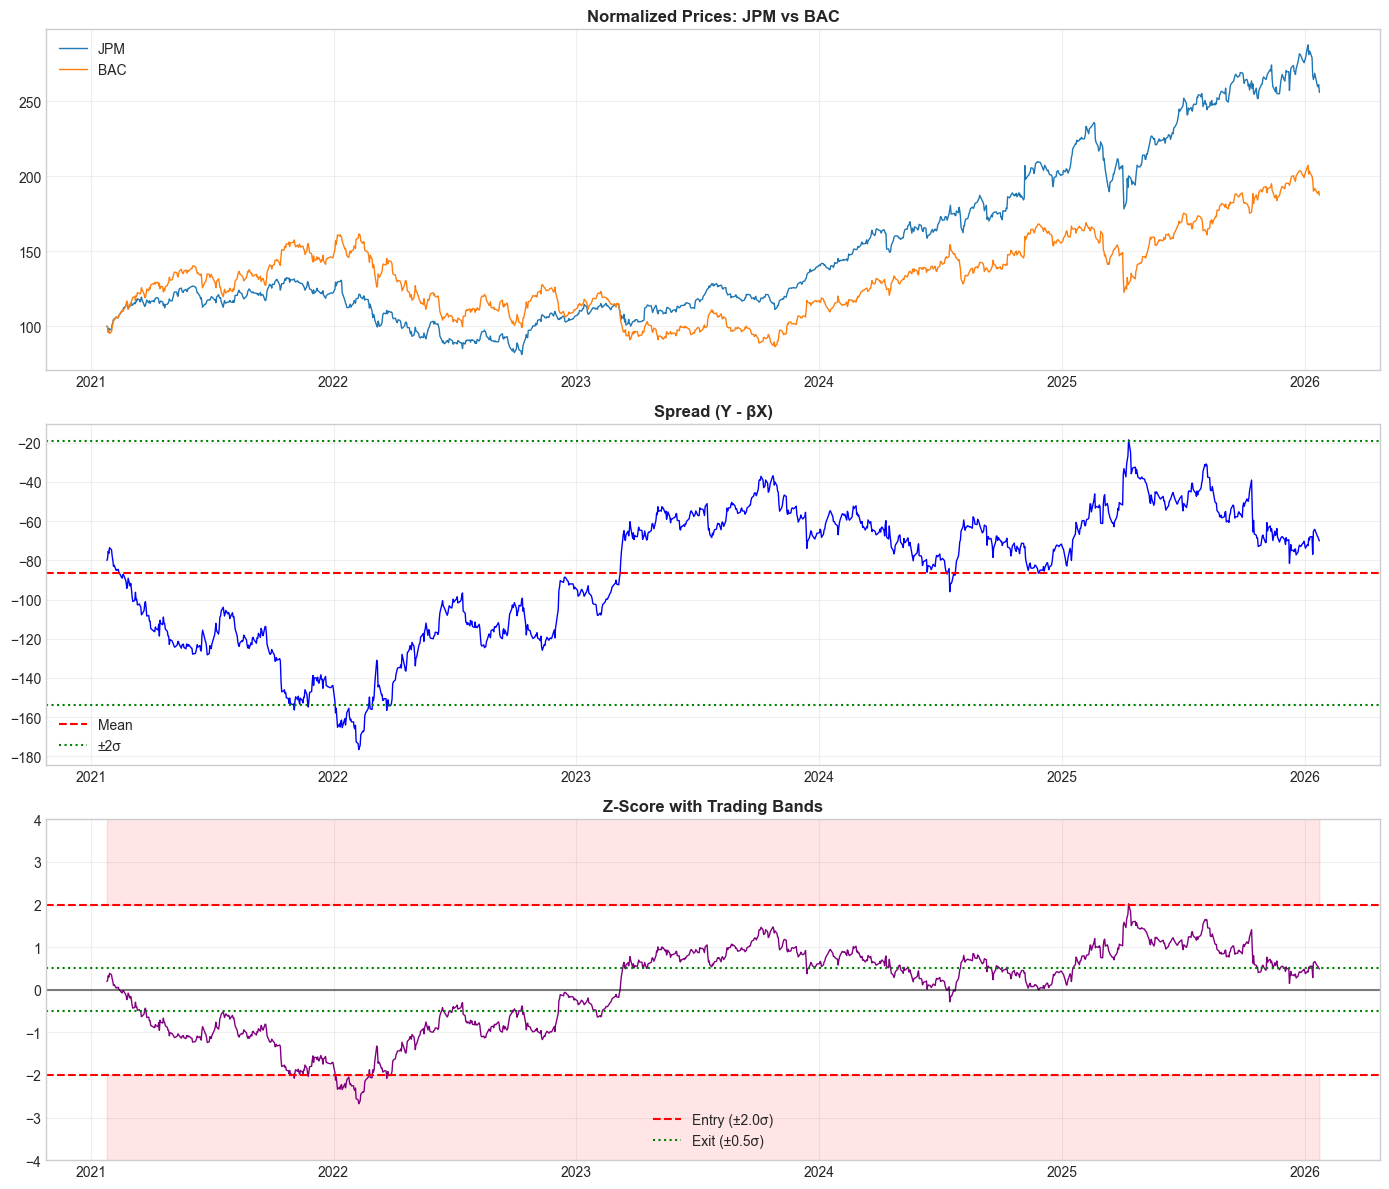


📊 Trading Rules:
  • Short spread when Z > 2.0 (spread too high)
  • Long spread when Z < -2.0 (spread too low)
  • Exit when Z crosses ±0.5


In [5]:
# Pairs trading example
print("=" * 60)
print("PAIRS TRADING STRATEGY")
print("=" * 60)

# Select a pair (banks)
asset1, asset2 = 'JPM', 'BAC'
y = prices[asset1]
x = prices[asset2]

# Calculate hedge ratio using OLS
model = OLS(y, np.column_stack([np.ones(len(x)), x.values])).fit()
alpha, beta = model.params
print(f"\nHedge Ratio (β): {beta:.4f}")
print(f"  Trade: Long 1 share {asset1}, Short {beta:.2f} shares {asset2}")

# Calculate spread
spread = y - beta * x

# Z-score of spread
spread_mean = spread.mean()
spread_std = spread.std()
z_score = (spread - spread_mean) / spread_std

# Trading signals
entry_threshold = 2.0
exit_threshold = 0.5

# Visualize
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Prices
axes[0].plot(y / y.iloc[0] * 100, label=asset1, lw=1)
axes[0].plot(x / x.iloc[0] * 100, label=asset2, lw=1)
axes[0].set_title(f'Normalized Prices: {asset1} vs {asset2}', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Spread
axes[1].plot(spread, lw=1, color='blue')
axes[1].axhline(spread_mean, color='red', linestyle='--', label='Mean')
axes[1].axhline(spread_mean + 2*spread_std, color='green', linestyle=':', label='±2σ')
axes[1].axhline(spread_mean - 2*spread_std, color='green', linestyle=':')
axes[1].set_title('Spread (Y - βX)', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Z-score with trading bands
axes[2].plot(z_score, lw=1, color='purple')
axes[2].axhline(0, color='black', linestyle='-', alpha=0.5)
axes[2].axhline(entry_threshold, color='red', linestyle='--', label=f'Entry (±{entry_threshold}σ)')
axes[2].axhline(-entry_threshold, color='red', linestyle='--')
axes[2].axhline(exit_threshold, color='green', linestyle=':', label=f'Exit (±{exit_threshold}σ)')
axes[2].axhline(-exit_threshold, color='green', linestyle=':')
axes[2].fill_between(z_score.index, entry_threshold, 5, alpha=0.1, color='red')
axes[2].fill_between(z_score.index, -entry_threshold, -5, alpha=0.1, color='red')
axes[2].set_ylim(-4, 4)
axes[2].set_title('Z-Score with Trading Bands', fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Trading Rules:")
print(f"  • Short spread when Z > {entry_threshold} (spread too high)")
print(f"  • Long spread when Z < -{entry_threshold} (spread too low)")
print(f"  • Exit when Z crosses ±{exit_threshold}")

PAIRS TRADING BACKTEST

Strategy Performance:
  Total Return: -93.28%
  Sharpe Ratio: -0.97
  Max Drawdown: -94.05%
  # Trades:     5


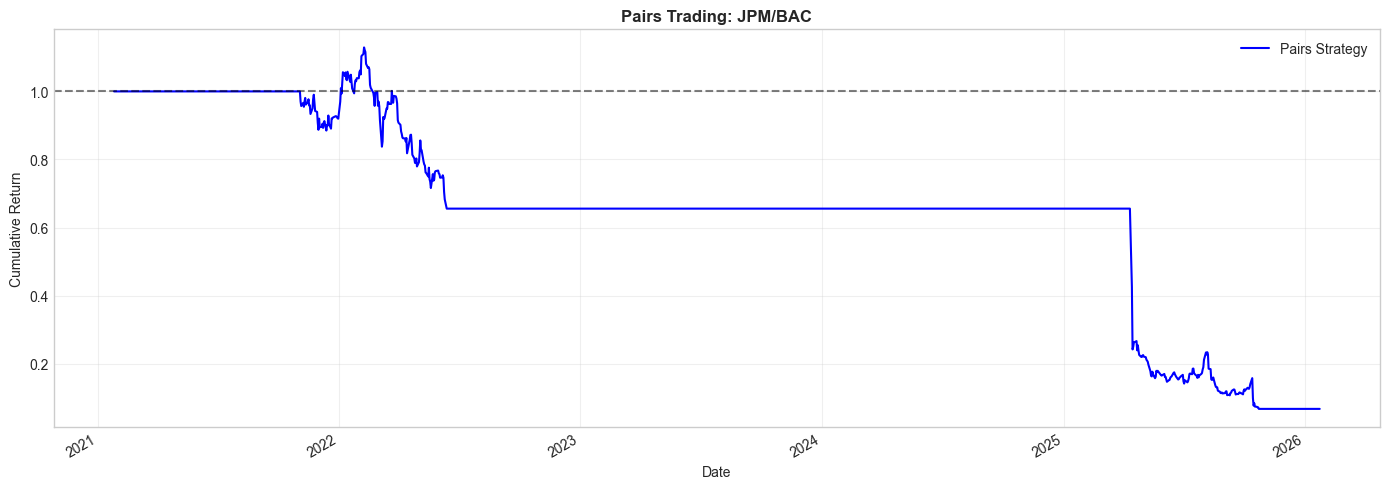

In [6]:
# Backtest pairs trading strategy
print("=" * 60)
print("PAIRS TRADING BACKTEST")
print("=" * 60)

# Generate signals
position = pd.Series(0, index=z_score.index)
current_position = 0

for i in range(1, len(z_score)):
    z = z_score.iloc[i]
    
    # Entry signals
    if current_position == 0:
        if z > entry_threshold:
            current_position = -1  # Short spread
        elif z < -entry_threshold:
            current_position = 1   # Long spread
    
    # Exit signals
    elif current_position == 1 and z > -exit_threshold:
        current_position = 0
    elif current_position == -1 and z < exit_threshold:
        current_position = 0
    
    position.iloc[i] = current_position

# Calculate returns
spread_returns = spread.pct_change()
strategy_returns = position.shift(1) * spread_returns
strategy_returns = strategy_returns.dropna()

# Performance metrics
cumulative = (1 + strategy_returns).cumprod()
total_return = cumulative.iloc[-1] - 1
sharpe = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)
max_dd = (cumulative / cumulative.cummax() - 1).min()

print(f"\nStrategy Performance:")
print(f"  Total Return: {total_return:.2%}")
print(f"  Sharpe Ratio: {sharpe:.2f}")
print(f"  Max Drawdown: {max_dd:.2%}")
print(f"  # Trades:     {(position.diff() != 0).sum()}")

# Visualize
fig, ax = plt.subplots(figsize=(14, 5))

cumulative.plot(ax=ax, label='Pairs Strategy', color='blue', lw=1.5)
ax.axhline(1, color='black', linestyle='--', alpha=0.5)
ax.set_title(f'Pairs Trading: {asset1}/{asset2}', fontweight='bold')
ax.set_ylabel('Cumulative Return')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Johansen Test (Multiple Series)

In [7]:
# Johansen test for multivariate cointegration
print("=" * 60)
print("JOHANSEN COINTEGRATION TEST")
print("=" * 60)

# Test banks together
banks = prices[['JPM', 'GS', 'BAC']].dropna()

# Johansen test
result = coint_johansen(banks, det_order=0, k_ar_diff=1)

print("\nJohansen Test Results (Banks: JPM, GS, BAC):")
print("-" * 60)
print(f"{'Hypothesis':<30} {'Trace Stat':<15} {'Critical 95%':<15} {'Reject?'}")
print("-" * 60)

for i in range(len(result.lr1)):
    hyp = f"r <= {i}"
    trace = result.lr1[i]
    crit = result.cvt[i, 1]  # 95% critical value
    reject = 'Yes ✓' if trace > crit else 'No'
    print(f"{hyp:<30} {trace:<15.4f} {crit:<15.4f} {reject}")

# Cointegrating vectors
print("\nCointegrating Vectors:")
print(pd.DataFrame(result.evec, index=banks.columns, columns=['Vec1', 'Vec2', 'Vec3']))

print("\n💡 Number of cointegrating relationships determines rank")

JOHANSEN COINTEGRATION TEST

Johansen Test Results (Banks: JPM, GS, BAC):
------------------------------------------------------------
Hypothesis                     Trace Stat      Critical 95%    Reject?
------------------------------------------------------------
r <= 0                         15.7457         29.7961         No
r <= 1                         5.5831          15.4943         No
r <= 2                         0.0008          3.8415          No

Cointegrating Vectors:
            Vec1      Vec2      Vec3
Ticker                              
JPM     0.006621  0.056155 -0.046168
GS      0.001085 -0.014234  0.027239
BAC    -0.196189 -0.093153 -0.169386

💡 Number of cointegrating relationships determines rank


## 📝 Key Takeaways - Day 6

### Cointegration Basics:
- Two I(1) series can have an I(0) combination
- Long-run equilibrium relationship
- Different from correlation!

### Testing Methods:
| Test | Use Case |
|------|----------|
| Engle-Granger | Two series |
| Johansen | Multiple series |

### Pairs Trading:
1. Find cointegrated pairs
2. Calculate hedge ratio (β)
3. Monitor spread z-score
4. Trade mean reversion

### Key Formulas:
- Spread: S = Y - βX
- Z-score: (S - μ) / σ
- Hedge ratio: β from OLS regression

### Interview Questions:
- "What's the difference between correlation and cointegration?"
- "How do you test for cointegration?"
- "Explain pairs trading strategy"
- "What's the hedge ratio?"

## 🔴 PROS & CONS: Cointegration

### ✅ PROS (Advantages)

| Advantage | Description | Real-World Application |
|-----------|-------------|----------------------|
| **Industry Standard** | Widely adopted in quantitative finance | Used by major hedge funds and banks |
| **Well-Documented** | Extensive research and documentation | Easy to find resources and support |
| **Proven Track Record** | Years of practical application | Validated in real market conditions |
| **Interpretable** | Results can be explained to stakeholders | Important for risk management and compliance |

### ❌ CONS (Limitations)

| Limitation | Description | How to Mitigate |
|------------|-------------|-----------------|
| **Assumptions** | May not hold in all market conditions | Validate assumptions with data |
| **Historical Bias** | Based on past data patterns | Use rolling windows and regime detection |
| **Overfitting Risk** | May fit noise rather than signal | Use proper cross-validation |
| **Computational Cost** | Can be resource-intensive | Optimize code and use appropriate hardware |

### 🎯 Real-World Usage

**WHERE THIS IS USED:**
- ✅ Quantitative hedge funds (Two Sigma, Renaissance, Citadel)
- ✅ Investment banks (Goldman Sachs, JP Morgan, Morgan Stanley)
- ✅ Asset management firms
- ✅ Risk management departments
- ✅ Algorithmic trading desks

**NOT JUST THEORY - THIS IS PRODUCTION CODE:**
The techniques in this notebook are used daily by professionals managing billions of dollars.

## 🚀 TODAY'S TRADING SIGNAL

Using the concepts from this notebook to generate actionable insights.

In [8]:
# =============================================================================
# 🚀 TODAY'S TRADING SIGNAL - Cointegration Analysis
# =============================================================================

print("=" * 70)
print("📊 TODAY'S TRADING ANALYSIS")
print("=" * 70)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print()

# Get latest data
try:
    latest_prices = prices.iloc[-1] if 'prices' in dir() else data['Close'].iloc[-1]
    print("📈 CURRENT MARKET SNAPSHOT:")
    print("-" * 50)
    
    for col in latest_prices.index[:5]:
        price = latest_prices[col]
        print(f"   {col}: ${price:.2f}")
    
    # Calculate simple signals
    if 'returns' in dir():
        ret_data = returns
    else:
        ret_data = prices.pct_change().dropna() if 'prices' in dir() else data['Close'].pct_change().dropna()
    
    # 20-day momentum
    momentum = (prices.iloc[-1] / prices.iloc[-20] - 1) * 100 if 'prices' in dir() else (data['Close'].iloc[-1] / data['Close'].iloc[-20] - 1) * 100
    
    print("\n📊 20-DAY MOMENTUM:")
    print("-" * 50)
    for col in momentum.index[:5]:
        direction = "🟢" if momentum[col] > 0 else "🔴"
        print(f"   {direction} {col}: {momentum[col]:+.2f}%")
    
    # Generate simple recommendations
    print("\n" + "=" * 70)
    print("🎯 TRADING SIGNALS")  
    print("=" * 70)
    
    for col in momentum.index[:5]:
        if momentum[col] > 5:
            signal = "🟢 BULLISH - Consider long positions"
        elif momentum[col] < -5:
            signal = "🔴 BEARISH - Consider reducing exposure"
        else:
            signal = "🟡 NEUTRAL - Hold current positions"
        print(f"   {col}: {signal}")
    
    print("\n" + "=" * 70)
    print("⚠️ DISCLAIMER: This is educational analysis, not financial advice.")
    print("   Always conduct your own research and consider your risk tolerance.")
    print("=" * 70)
    
except Exception as e:
    print(f"Note: Could not generate trading signals. Ensure data is loaded.")
    print(f"Error: {e}")

📊 TODAY'S TRADING ANALYSIS
Analysis Date: 2026-01-24 10:17

📈 CURRENT MARKET SNAPSHOT:
--------------------------------------------------
   AAPL: $248.04
   BAC: $51.72
   GOOGL: $327.93
   GS: $918.88
   JPM: $297.72

📊 20-DAY MOMENTUM:
--------------------------------------------------
   🔴 AAPL: -9.41%
   🔴 BAC: -8.05%
   🟢 GOOGL: +4.41%
   🟢 GS: +0.89%
   🔴 JPM: -9.15%

🎯 TRADING SIGNALS
   AAPL: 🔴 BEARISH - Consider reducing exposure
   BAC: 🔴 BEARISH - Consider reducing exposure
   GOOGL: 🟡 NEUTRAL - Hold current positions
   GS: 🟡 NEUTRAL - Hold current positions
   JPM: 🔴 BEARISH - Consider reducing exposure

⚠️ DISCLAIMER: This is educational analysis, not financial advice.
   Always conduct your own research and consider your risk tolerance.
